In [1]:
from recommendation_engine import Movie_recomendation_system,Recommendation_tools

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [14]:
sns.set()

In [3]:
user_preference = Recommendation_tools.get_user_preference()

#### A benchmark of the time taken to make movie recommmendations

In [4]:
%%time
Movie_recomendation_system.recommendation_by_favourite_movie(user_preference,12,'Quiz Show (1994)')

Wall time: 935 ms


['Usual Suspects, The (1995)',
 'Shawshank Redemption, The (1994)',
 'Fugitive, The (1993)',
 'Groundhog Day (1993)',
 'Field of Dreams (1989)',
 'Toy Story (1995)',
 'Empire Strikes Back, The (1980)',
 'Terminator 2: Judgment Day (1991)',
 'Stand by Me (1986)',
 'Jaws (1975)',
 'Pulp Fiction (1994)',
 'Heat (1995)']

In [5]:
%%time
Movie_recomendation_system.recommendation_by_favourite_movie(user_preference,23,'Aliens (1986)')

Wall time: 474 ms


['Terminator 2: Judgment Day (1991)',
 'Die Hard (1988)',
 'Terminator, The (1984)',
 'Star Trek: First Contact (1996)',
 'Star Trek: The Wrath of Khan (1982)',
 'Raiders of the Lost Ark (1981)',
 'Star Wars (1977)',
 'Empire Strikes Back, The (1980)',
 'Alien (1979)',
 'Return of the Jedi (1983)',
 'Twelve Monkeys (1995)',
 'Monty Python and the Holy Grail (1974)',
 'Back to the Future (1985)',
 'Jurassic Park (1993)',
 'Men in Black (1997)',
 'Rock, The (1996)',
 'Independence Day (ID4) (1996)',
 'Jaws (1975)',
 'Aladdin (1992)',
 'Hunt for Red October, The (1990)']

### Result :

#### **This shows that the model with scale well in production with a peak time of  937 ms for prediction** 

## Evaluating the recommendation system


### dropping duplicates to avoid data leakage

In [6]:
user_preference = user_preference.drop_duplicates(subset =  ['user_id','movie_title']).reset_index()

### splitting the dataset into train and test set using a ration of 70 : 30

In [7]:
data_length = len(user_preference)
train_size =  int(0.7 * data_length)
test_size =  data_length - train_size

In [8]:
train_set = user_preference.sample(n = train_size,random_state=42)
train_index = train_set.index
test_index = [index for index in user_preference.index if index not in train_index]
test_set = user_preference.loc[test_index]

### This function returns the accuracy of predicted movies for a singe user

In [9]:
def prediction_single_user(train_set,test_set,user_id,min_rating = 4,metric_to_use = 'cosine'):
    '''
    prediction using the recommendation_by_favourite_movie
    '''
    # the assumed favorite movie of a user is any movie that the user has watched and has given rating of at least 4
    try:
        fav_movie = train_set[(train_set.user_id == user_id) &  (train_set.rating >=min_rating)].iloc[0].movie_title
        
        # THis generates a list of movies that the user has watched in the the test set with a rating of at least 4
        ground_truth = test_set[(test_set.user_id == user_id) & (test_set.rating >=min_rating)].movie_title.to_list()
    
    # This returns a movie with a lower rating if the target user has not watched movies with a rating >= min_rating
        
    except IndexError:
        min_rating -= 1
        fav_movie = train_set[(train_set.user_id == user_id) &  (train_set.rating >=min_rating)].iloc[0].movie_title
        ground_truth = test_set[(test_set.user_id == user_id) & (test_set.rating >=min_rating)].movie_title.to_list()
        
    # Generates similar movies to the user's favorite movie
    prediction = Movie_recomendation_system.recommendation_by_favourite_movie(train_set,user_id,fav_movie,metric_to_use )
    # Generates a list of predicted movies that are in the ground truth 
    correct_prediction = [x for x in prediction if x in ground_truth ]
    
    # returns the accuracy of predicted results to the ground truth 
    try :
        accuracy_fav_sys  = len(correct_prediction)/len(ground_truth)
    except ZeroDivisionError:
        accuracy_fav_sys = 0
   
    return accuracy_fav_sys

### Generates the accuracy of prediction for each user in the test set

In [10]:
%%time
index_to_use = test_set.user_id.unique()
metrics = ['cosine','euclidean','canberra','chebyshev','correlation']
accuracy = [[prediction_single_user(train_set,test_set,user_id,min_rating = 4,metric_to_use = metric) for user_id in index_to_use] for metric in metrics ]

Wall time: 38min 5s


In [11]:
accuracy_data = pd.DataFrame(np.array(accuracy).T,columns = metrics)
accuracy_data.head()

,cosine,euclidean,canberra,chebyshev,correlation
0,0.000000,0.000000,0.000000,0.058824,0.000000
1,0.151515,0.121212,0.060606,0.000000,0.121212
2,0.000000,0.000000,0.000000,0.066667,0.000000
3,0.038961,0.025974,0.025974,0.025974,0.025974
4,0.000000,0.100000,0.000000,0.000000,0.000000


### Generates a plot of the accuracy across each metric for the first 30 user_id in the  test set

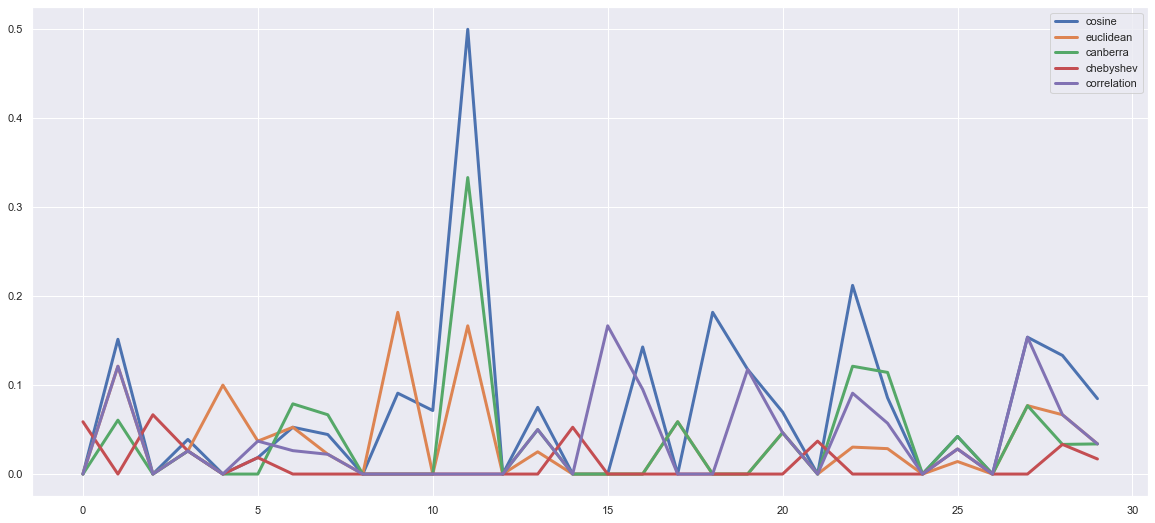

In [40]:
accuracy_data.iloc[:30].plot(figsize = (20,9),lw=3)

### result sorted with correlation metric

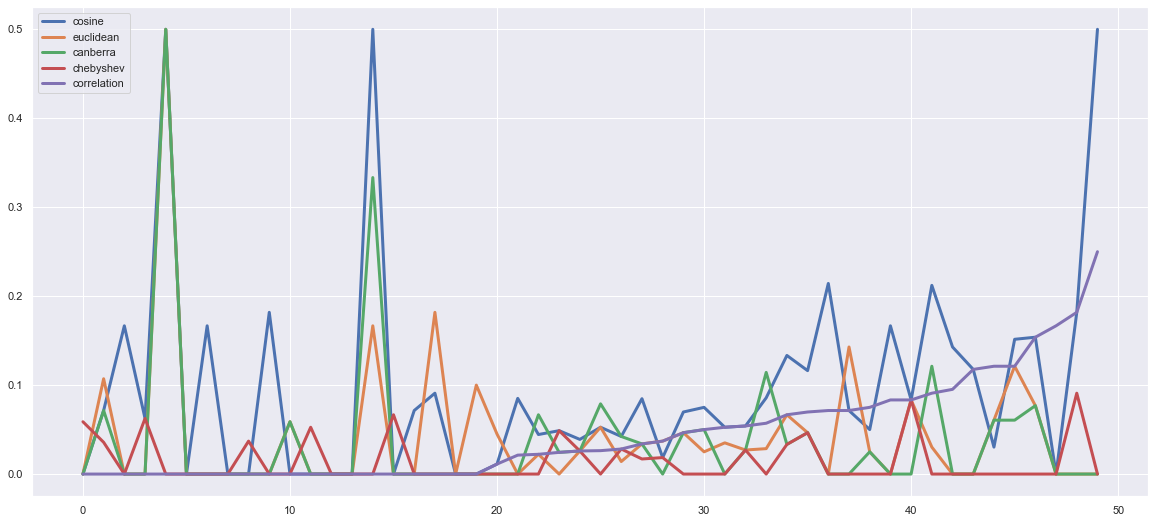

In [45]:
accuracy_data.iloc[:50].sort_values(by = 'correlation').reset_index(drop = True).plot(figsize = (20,9),lw = 3)

### result sorted with cosine metric

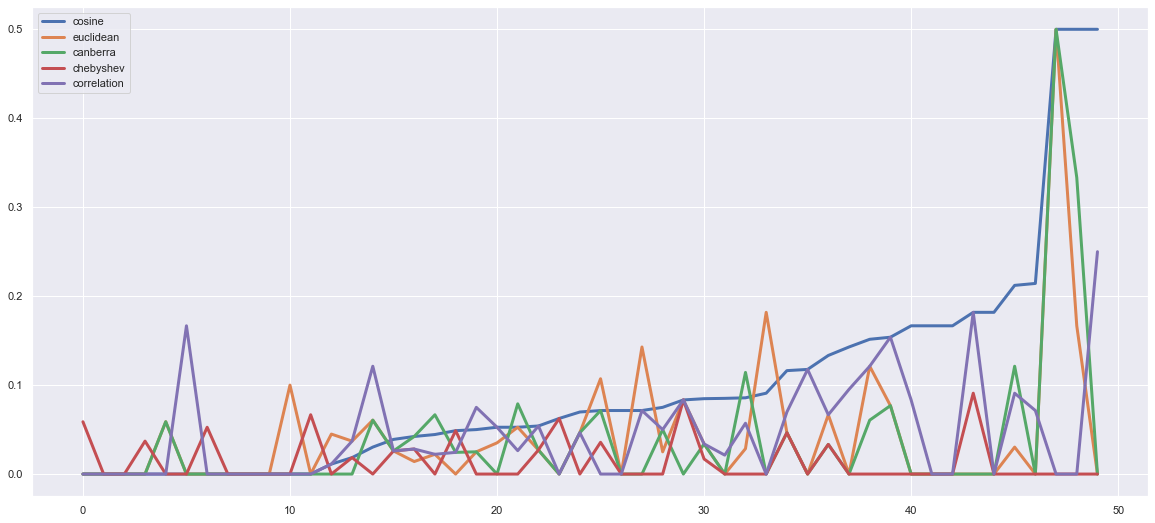

In [44]:
accuracy_data.iloc[:50].sort_values(by = 'cosine').reset_index(drop = True).plot(figsize = (20,9),lw = 3)

### Result :

#### **The above graph shows that the number of null accurate predictions for cosine metric is lower than that of correlation metric** 


In [46]:
#### **The above graph also shows that the peak accuracy for cosine metric is higher than that of correlation metric** 

### Generates a plot of the weighted accuracy across each metric for the test set

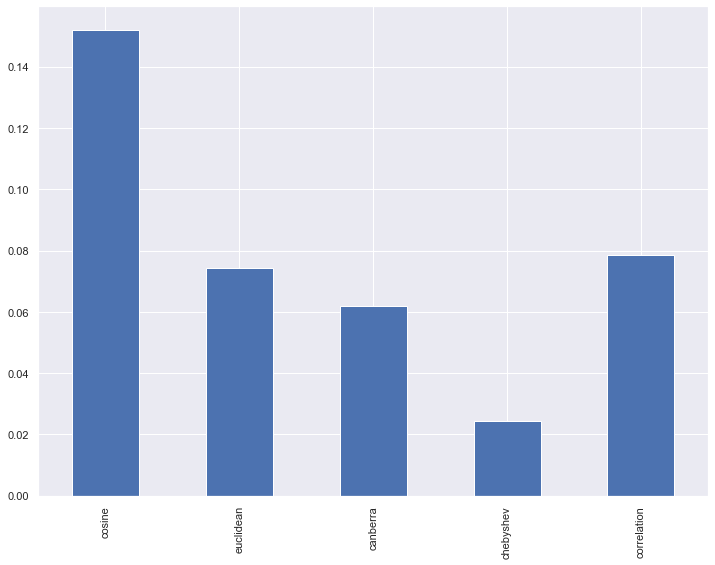

In [33]:
accuracy_data.mean().plot(kind  = 'bar',figsize = (12,9))

### Result :

#### **The metric with the higest accuracy is the cosine metric** 